In [1]:
import pandas as pd

details = pd.read_csv("./dw/details.csv")
fatalities = pd.read_csv("./dw/fatalities.csv")
location = pd.read_csv("./dw/location.csv")
duration = pd.read_csv("./dw/duration.csv")
narrative = pd.read_csv("./dw/narrative.csv")
storm = pd.read_csv("./dw/storm.csv")

print(f"Details len: {len(details)}")
print(f"location len: {len(location)}")
print(f"fatalities len: {len(fatalities)}")

/tmp/ipykernel_235004/317168014.py:3: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv("./dw/details.csv")


Details len: 1705613
location len: 693971
fatalities len: 22807


### WordCloud with words describing events that happened within a 300km range from Oklahoma City after 2019 and have similarity to the sentence 'flash flood, heavy rain, floods'

This will use the following model for embedding: sentence-transformers/all-MiniLM-L6-v2 available on Huggingface

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from distance import DistanceFunctions
from helpers import Helpers

OKLAHOMA_POINT = (35.46, -97.54)

dist = DistanceFunctions()
help = Helpers()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function for calculating if a point is inside the range
def is_within_radius(row, center, radius_km):
    try:
        point = [row['latitude'], row['longitude']]
        return dist.haversine([center[0], center[1]], point) <= radius_km
    except:
        return False


# Merging dimensions into one dataframe
stormevents = storm.merge(details, left_on='details_id', right_on='details_id')
stormevents = stormevents.merge(
    location, left_on='location_id', right_on='location_id')
stormevents = stormevents.merge(
    duration, left_on='duration_id', right_on='duration_id')
stormevents = stormevents.merge(
    narrative, left_on='narrative_id', right_on='narrative_id')


# Filtering for events since 2019
stormevents = stormevents[stormevents['begin_year'] >= 2019]


# Filtering for points within a 300km range from Oklahoma City
stormevents = stormevents[stormevents.apply(
    lambda row: is_within_radius(row, OKLAHOMA_POINT, 300), axis=1)]

# Calculating embbedding for distance
string = "flash flood, heavy rain, floods"
stringEmbbed = help.generate_text_embedding(string)

stormevents['embbeding'] = stormevents['full_narrative'].apply(
    help.generate_text_embedding)
stormevents['distance'] = stormevents['embbeding'].apply(
    lambda x: dist.cosine(x, stringEmbbed))
stormevents = stormevents[stormevents['distance'] > 0.5]

# Removing empty narratives
text = stormevents['full_narrative'].dropna().tolist()

# Cleaning the texts
text = re.sub(r'[^\w\s]', '', text.lower())

# Removing stopwords
filtered_words = [word for word in text.split() if word not in stop_words]

# Generating the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(filtered_words))

# Plot the graph
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Line chart depicting the total damages caused by 

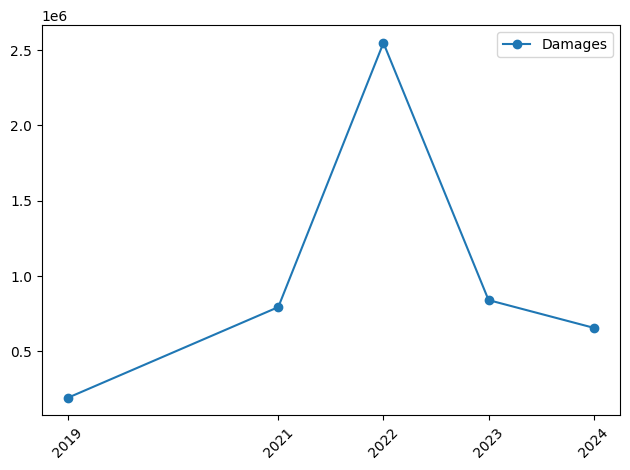

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from distance import DistanceFunctions

dist = DistanceFunctions()
OKLAHOMA_POINT = (35.46, -97.54)
# Function for calculating if a point is inside the 300km range
def is_within_radius(row, center, radius_km):
    try:
        point = [row['latitude'], row['longitude']]
        return dist.haversine([center[0], center[1]], point) <= radius_km
    except:
        return False

# Merging the dimensions into one dataframe
stormevents = storm.merge(
    details, left_on='details_id', right_on='details_id')
stormevents = stormevents.merge(
    location, left_on='location_id', right_on='location_id')
stormevents = stormevents.merge(
    duration, left_on='duration_id', right_on='duration_id')
stormevents = stormevents.merge(
    narrative, left_on='narrative_id', right_on='narrative_id')

# Filtering the DataFrame for specific event_types
stormevents = stormevents[stormevents['event_type'].isin(
    ['Flash Flood', 'Flood', 'Heavy rain'])]

# Filtering the dataframe for events since 2019
stormevents = stormevents[stormevents['begin_year'] >= 2019]

# Filtering for points in the 300km range from Oklahoma City (central point)
stormevents = stormevents[stormevents.apply(
    lambda row: is_within_radius(row, OKLAHOMA_POINT, 300), axis=1)]

# Grouping damages by year
damages_by_year = stormevents.groupby(
    'begin_year')['total_damages'].sum().reset_index()

# Plotting the graph
plt.plot(damages_by_year['begin_year'], damages_by_year['total_damages'],
         marker='o', linestyle='-', label='Damages')
plt.legend()
plt.xticks(ticks=damages_by_year['begin_year'], labels=[
           str(int(year)) for year in damages_by_year['begin_year']])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Merging the dimensions into one dataframe
stormevents = storm.merge(details, left_on="details_id", right_on="details_id")
stormevents = stormevents.merge(
    location, left_on="location_id", right_on="location_id")
stormevents = stormevents.merge(
    duration, left_on="duration_id", right_on="duration_id")

# Filtering for tornados only

tornado_df = stormevents[stormevents["event_type"] == "Tornado"]

# KNN feature selection

features = ['tor_length', 'tor_width', 'total_damages', 'total_injuries']
target = 'tor_f_scale'

cleaned_knn_df = tornado_df.dropna(subset=features + [target])

class_df = cleaned_knn_df['tor_f_scale']
classify_df = cleaned_knn_df[[
    'total_damages', 'total_injuries', 'total_deaths', 'tor_length', 'tor_width']]

classify_df = classify_df.rename(mapper={'total_damages': 'damages', 'total_deaths': 'deaths',
                                 'total_injuries': 'injuries', 'tor_length': 'torLength', 'tor_width': 'torWidth'}, axis='columns')


# KNN train-test split for getting data with and without the EF scale

X_train, X_test, y_train, y_test = train_test_split(
    classify_df, class_df, test_size=0.3, random_state=42)

# Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
X_test['classifier'] = y_pred
X_test


,damages,injuries,deaths,torLength,torWidth,classifier
270084,0,0,0,1.00,50.0,EF0
5440,0,0,0,1.58,25.0,EF0
88819,25000,0,0,0.12,25.0,EF0
233478,0,0,0,0.11,20.0,EF0
395021,0,0,0,3.39,100.0,EF1
...,...,...,...,...,...,...
249801,0,0,0,0.35,80.0,EF0
408321,0,0,0,0.21,75.0,EF0
354551,75000,0,0,6.40,550.0,EF1
20354,2000000,25,3,30.57,1320.0,EF2


24076


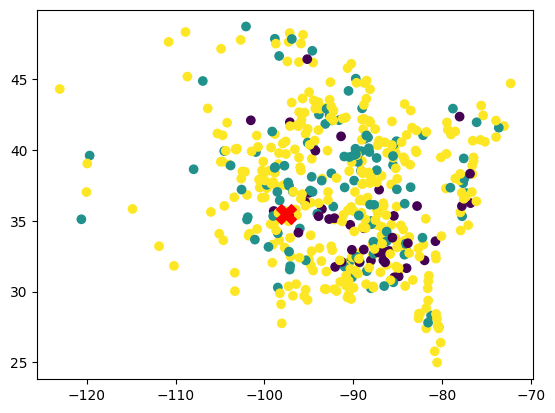

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



tornado_ids = details[details['event_type'] == 'Tornado']['details_id']
storm_tornado = storm[storm['details_id'].isin(tornado_ids)]

stormevents = storm_tornado.merge(
    details, left_on='details_id', right_on='details_id', suffixes=('', '_d'))
stormevents = stormevents.merge(
    duration, left_on='duration_id', right_on='duration_id', suffixes=('', '_dur'))
stormevents = stormevents.merge(
    location, left_on='location_id', right_on='location_id', suffixes=('', '_loc'))
stormevents = stormevents.dropna(
    subset=['latitude', 'longitude', 'tor_f_scale', 'tor_length', 'tor_width'])

stormevents = stormevents.sample(n=500)


def string_to_numeric(value):
    categories = [
        'EFU', 'EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5',
        'F0', 'F1', 'F2', 'F3', 'F4'
    ]
    mapping = {category: idx for idx, category in enumerate(categories)}

    return mapping.get(value, -1)


stormevents['tor_f_scale'] = stormevents['tor_f_scale'].apply(
    string_to_numeric)

X = stormevents[['tor_f_scale', 'tor_length', 'tor_width', 'begin_year']]
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3])

stormevents['cluster'] = kmeans.fit_predict(X_scaled)

plt.scatter(stormevents['longitude'],
            stormevents['latitude'], c=stormevents['cluster'])

plt.scatter(
    -97.54,
    35.46,
    color='red',
    s=200,
    label="Ponto Central",
    marker='X'
)
plt.show()
